In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb

from scipy.stats import chi2

import corner

import copy

# Problem 1

In [2]:
# ------ Copy-pasted from planck_likelihood.py ----------------------------------------------------------------

def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
dof = len(resid)-len(pars)
print("chisq is ",chisq," for ",dof,"degrees of freedom. Using",list(pars))

# --------------------------------------------------------------------------------------------------------------------

# Now use new parameters

newpars = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
newmodel = get_spectrum(newpars)
newmodel = newmodel[:len(spec)]
newres = spec-newmodel
newchisq = np.sum((newres/errs)**2)
print("chisq is",newchisq,"for",dof,"degrees of freedom. Using",list(newpars))

# In order to determine if these are 'good' chi-squared values, find the p-value

p1 = chi2.sf(chisq,dof)
p2 = chi2.sf(newchisq,dof)

print("\nThe p-value for",list(pars),"is",p1)
print("The p-value for",list(newpars),"is",p2)

chisq is  15264.645406788037  for  2501 degrees of freedom. Using [60.0, 0.02, 0.1, 0.05, 2e-09, 1.0]
chisq is 3272.5723646011556 for 2501 degrees of freedom. Using [69.0, 0.022, 0.12, 0.06, 2.1e-09, 0.95]

The p-value for [60.0, 0.02, 0.1, 0.05, 2e-09, 1.0] is 0.0
The p-value for [69.0, 0.022, 0.12, 0.06, 2.1e-09, 0.95] is 1.100148080038718e-23


# Problem 2

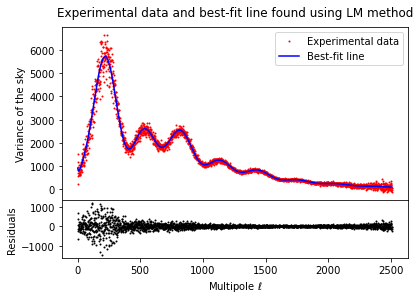

The p-value for best-fit parameters [68.53646002744289, 0.022426666983370813, 0.1168481352348479, 0.00730866986385691, 1.8962720817833285e-09, 0.9724003484485261] and uncertainty [1.83758278e-03 1.16405770e-06 3.27797712e-06 7.65413645e-06
 2.90471102e-14 2.22938697e-05] is 0.11948073413294431
The final chi-square value is 2584.532019470198


In [3]:
# Use Levenberg-Marquardt method to find best-fit parameters

# First, define a function that takes the gradient:

def grad(fun, params, delta):
    ''' Use numerical differentiator from problem set 1 problem 1
    Tweak it a little so it returns the gradient
    Here delta is an ARRAY --> different delta for each parameter'''
    
    gradient = np.zeros([2507,params.size])  # 2507 is the size of our experimental dataset
    
    # Take the derivative of ONE parameter at a time --> iterate over parameters
    for i,par in enumerate(params):
        
        par_plus = copy.deepcopy(params)
        par_2plus = copy.deepcopy(params)
        par_minus = copy.deepcopy(params)
        par_2minus = copy.deepcopy(params)
        
        par_plus[i] += delta[i]
        par_2plus[i] += 2*delta[i]
        par_minus[i] -= delta[i]
        par_2minus[i] -= 2*delta[i]
        
        # Take derivative from param+-delta
        deriv_1 = (fun(par_plus) - fun(par_minus))/(2*delta[i])
        
        # Take derivative from param+-2delta
        deriv_2 = (fun(par_2plus) - fun(par_2minus))/(4*delta[i])
        
        # Combine them
        deriv = 4/3 * deriv_1 - 1/3 * deriv_2
        
        # Stick them to the gradient
        gradient[:,i] = deriv[:2507]
        
    return gradient


def update_lambda(lamb, success):
    ''' From lm_class.py (seen in class) '''
    if success:
        lamb = lamb/1.5
        if lamb<0.5:
            lamb=0
    else:
        if lamb==0:
            lamb=1
        else:
            lamb = lamb*1.5**2
    return lamb


def fit_lm(fun, params, data, errs, delta, niter=25):
    ''' Adapted from lm_class.py (seen in class) '''
    
    # Initialize noise matrix
    N = np.zeros((2507,2507))
    for i in range(len(N)):
        N[i,i] = errs[i]
    
    lamb = 0
    # Get first chi-square value with guess parameters
    model = fun(params)[:2507]
    chisq_old = np.sum(((model-data)/errs)**2)
    
    for i in range(niter):
        
        # Calculate model and local gradient
        model = fun(params)[:2507]
        gradient = grad(fun, params, delta)
        
        # Calculate residuals
        r = data - model
        
        # Initialize left-hand-side and right-hand-side in linear algebra problem
        lhs = gradient.T@np.linalg.inv(N)@gradient
        lhs = lhs + lamb*np.diag(np.diag(lhs))  # Do the lambda thing for Levenberg-Marquardt
        
        rhs = gradient.T@np.linalg.inv(N)@r
        
        # Ideally use inverse, but make it fail-proof in case of uninvertible matrix
        try:
            curvature_matrix = np.linalg.inv(lhs)
        except:
            curvature_matrix = np.linalg.pinv(lhs)
            
        dm = curvature_matrix@rhs
        
        # Check out how the step we just took works
        p_trial = params + dm
        model = fun(p_trial)[:2507]
        chisq = np.sum(((data-model)/errs)**2)
        
        # Decide whether to accept the step or not
        if (chisq<chisq_old):
            lamb = update_lambda(lamb, True)
            params += dm
            chisq_old = chisq
        else:
            lamb = update_lambda(lamb, False)
            
    return params, chisq, curvature_matrix

    
# Define a delta array to calculate the gradient (just go a few orders of magnitude below the corresponding param value)
delta = np.asarray([1e-2, 1e-5, 1e-4, 1e-5, 1e-12, 1e-4])

# Start with a guess for parameters (use second set of parameters presented in problem set)
pars_guess = np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

# Get the best-fit LM parameters and the chi-square
best_pars, best_chisq, curvmat = fit_lm(get_spectrum, pars_guess, spec, errs, delta)

# Get the p-value
p_final = chi2.sf(best_chisq,dof)


# Plot my best-fit parameters to see if it looks good

best_data = get_spectrum(best_pars)[:2507]

fig = plt.figure(0)

top = fig.add_axes((.1,.3,.8,.6))
plt.plot(ell, spec, '.', markersize=2, color='red', label="Experimental data")
plt.plot(ell, best_data, color='blue',label="Best-fit line")
plt.legend()
plt.ylabel("Variance of the sky")
plt.title("Experimental data and best-fit line found using LM method",y=1.03)

res = spec-best_data
bot = fig.add_axes((.1,.1,.8,.2))
plt.plot(ell,res, '.', markersize=2, color='k')
plt.ylabel("Residuals")
plt.xlabel(r"Multipole $\ell$")
#plt.savefig("multipole_with_res.png",dpi=500,bbox_inches='tight')

plt.show()


# Finally, insert everything into a text file

param_errs = np.sqrt(np.diag(curvmat))
param_name_list = ["Hubble constant","Baryon density","Dark matter density","Optical depth",\
                   "Primordial amplitude","Primordial tilt"]

with open("planck_fit_params.txt",'w') as f:
    f.write("Parameter name\tParameter value\tParameter uncertainty\n")
    for i,c in enumerate(best_pars):
        f.write(f"{param_name_list[i]}\t{c}\t{param_errs[i]}\n")
    
print("The p-value for best-fit parameters",list(best_pars),"and uncertainty",param_errs,"is",p_final)
print("The final chi-square value is",best_chisq)

# Problem 3

In [5]:
# First define a get chi-square function to get the chi-square

def get_chisq(theta, y, yerr):
    ''' Here theta are our parameters (6-dimensional in our case)'''
    model = get_spectrum(theta)[:2507]
    return np.sum(((y-model)/yerr)**2)


# Then, write the Metropolis-Hastings algorithm!
def run_mcmc(theta_collection, num_iter=100000, filename='planck_chain', tau_prior=False):
    
    for k in range(num_iter-1):
    
        # Pick up where we left off
        current_theta = theta_collection[-1]
        chisq_old = get_chisq(current_theta, y=spec, yerr=errs)
        
        # Commit results to text file (in case computer crashes or encounters RAM issues)
        with open(f"{filename}.txt",'a') as f:
            f.write(f"{chisq_old}\t")
            for j in current_theta:
                f.write(f"{j}\t")
            f.write("\n")
    
        # Propose a jump to a random location
        proposed_jump = np.zeros_like(current_theta)
    
        # Check if I'm applying a prior on tau (Problem 4)
        if not tau_prior:
            for i in range(current_theta.size):
                proposed_jump[i] = np.random.normal(loc=current_theta[i], scale=2*param_errs[i], size=1)  # HARD-CODED part
                                                                                                          # Beware.....
        if tau_prior:
            for i in range(current_theta.size):
                if i == 3:
                    proposed_jump[i] = np.random.normal(loc=0.054, scale=0.0074, size=1)
                else:
                    proposed_jump[i] = np.random.normal(loc=current_theta[i], scale=2*param_errs[i],size=1)
            
            
        # Calculate the chisq at the proposed position
        chisq_new = get_chisq(proposed_jump, y=spec, yerr=errs)
    
        # Accept or reject step
        if chisq_new < chisq_old:
            theta_collection.append(proposed_jump)
        
        else:
            delta = chisq_new - chisq_old
            prob = np.exp(-0.5*delta)
            if np.random.rand() < prob:
                theta_collection.append(proposed_jump)
            else:
                theta_collection.append(current_theta)
                
    return theta_collection

        
# Finally, try it out!
#theta_collection = [best_pars]  # My initial guess is the best-fit params from LM method

#run_mcmc(theta_collection)


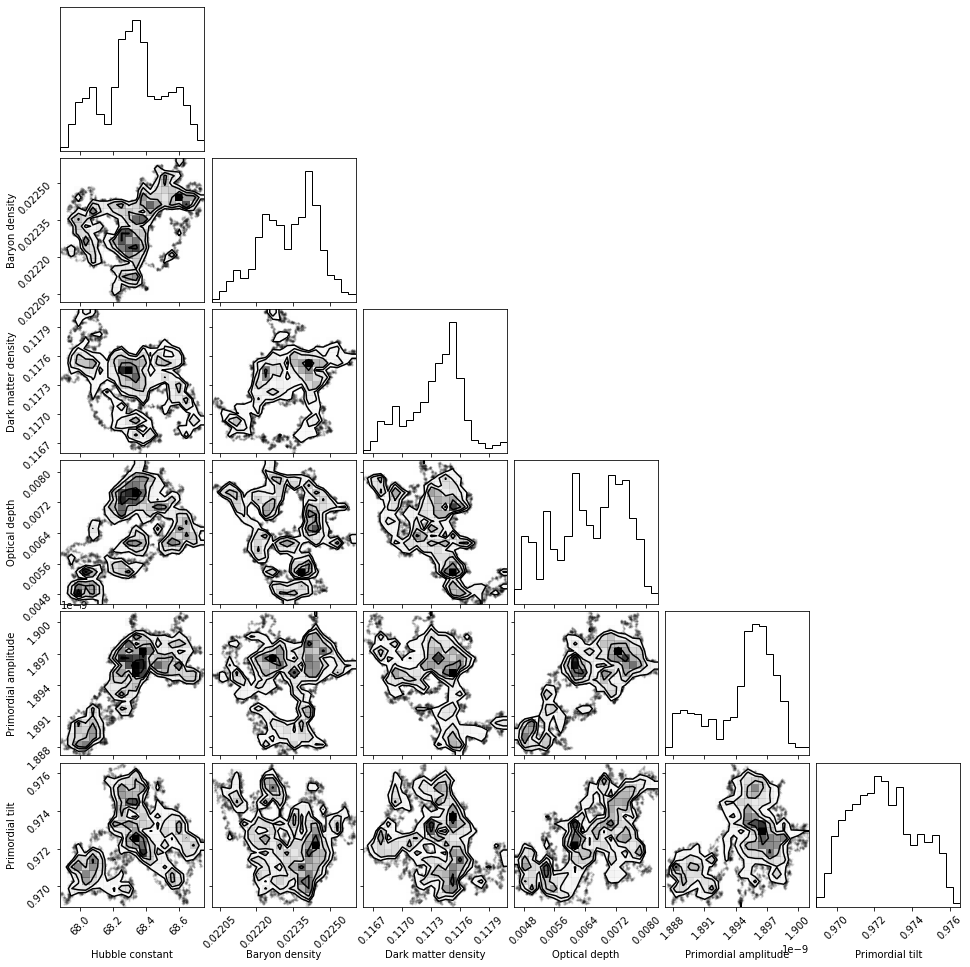

The best-fit parameters found using MCMC are: [68.32590826914311, 0.02232976045627665, 0.11734089271932001, 0.0065132705626844796, 1.8946950089017825e-09, 0.9724916801978987] with uncertainties [0.19406440184263382, 0.00011597559330695177, 0.00028618513532052995, 0.0009076807126535611, 3.105086520707186e-12, 0.00170160402816962]

chisq is 2583.617838866597 and p-value is 0.12202181617468909


In [7]:
# Use corner plot to visualize results

theta_collection = np.asarray(theta_collection)

corner.corner(theta_collection[200:], labels=param_name_list)
plt.savefig("cornerplot.png",dpi=500,bbox_inches='tight')
plt.show()


# Finally, the best-fit parameters are given by the mean +- std of the chain
means = []
stds = []
for i in range(theta_collection.shape[1]):
    means.append(np.mean(theta_collection[200:,i]))  # Remove 200 as burn-in
    stds.append(np.std(theta_collection[200:,i]))
    
print("The best-fit parameters found using MCMC are:",means,"with uncertainties",stds)

with open("mcmc_fit_params.txt",'w') as f:
    f.write("Parameter name\tParameter value\tParameter uncertainty\n")
    for i,c in enumerate(means):
        f.write(f"{param_name_list[i]}\t{c}\t{stds[i]}\n")
        
        
# Finally, get the chi-square and p-value for best-fit params
mcmc_chisq = np.sum(((spec-get_spectrum(means)[:2507])/errs)**2)
mcmc_p = chi2.sf(mcmc_chisq,dof)

print("\nchisq is",mcmc_chisq,"and p-value is",mcmc_p)


In [20]:
# Finally, get the dark energy
# Just use uncertainties package, it does everything for you

from uncertainties import ufloat

H0 = ufloat(means[0], stds[0])
h = H0/100

ob = ufloat(means[1],stds[1])
oc = ufloat(means[2],stds[2])

omega_b = ob/(h**2)
omega_c = oc/(h**2)

omega_lambda = 1 - omega_b - omega_c

print("Mean value of dark matter energy with uncertainty is",omega_lambda)

Mean value of dark matter energy with uncertainty is 0.7008+/-0.0018


# Problem 4

In [12]:
# First, run an entirely new chain

#new_pars = copy.deepcopy(best_pars)
#new_pars[3] = 0.054

#new_chain = [new_pars]
#run_mcmc(new_chain, filename='planck_chain_tauprior', tau_prior=True)

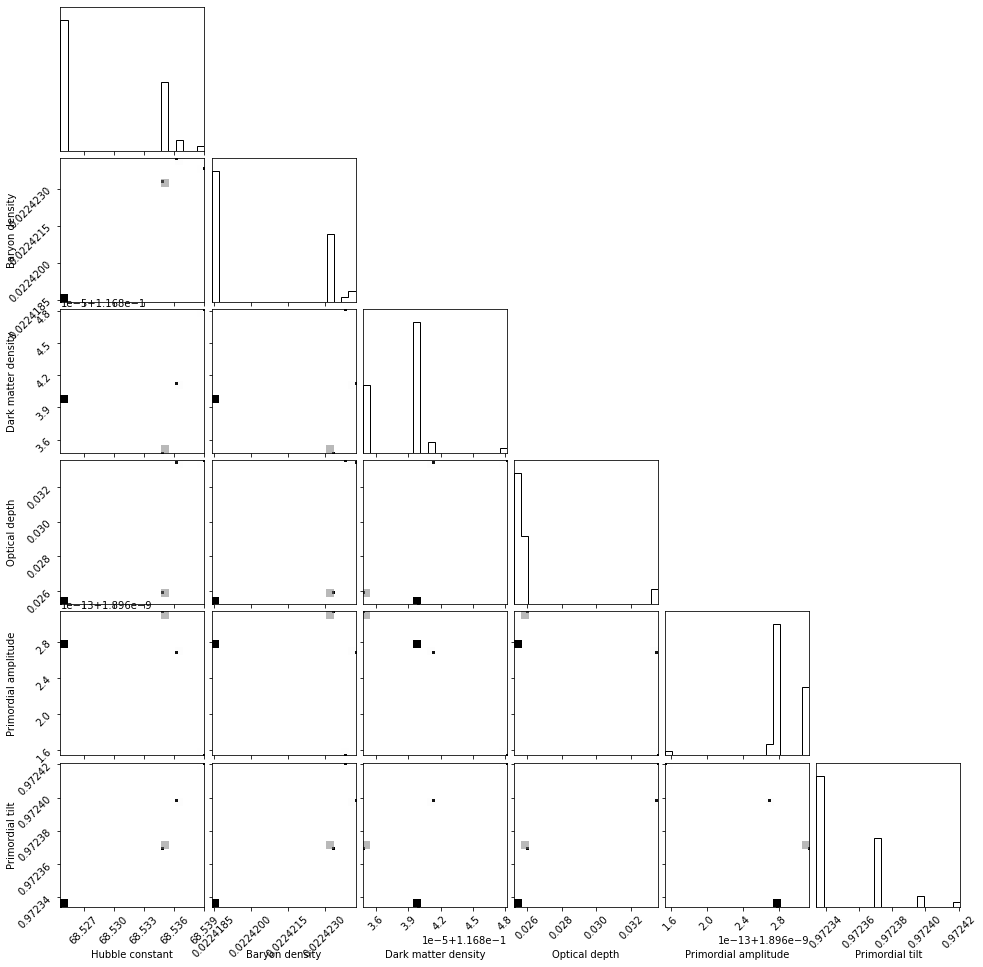

The best-fit parameters found using MCMC (using prior on tau) are: [68.32590826914311, 0.02232976045627665, 0.11734089271932001, 0.0065132705626844796, 1.8946950089017825e-09, 0.9724916801978987] with uncertainties [0.19406440184263382, 0.00011597559330695177, 0.00028618513532052995, 0.0009076807126535611, 3.105086520707186e-12, 0.00170160402816962]

chisq is 2583.617838866597 and p-value is 0.12202181617468909

The best-fit parameters found using MCMC (using prior on tau and importance sampling) are: [68.32453105851896, 0.02233056975986829, 0.11734111639266555, 0.006501118471798809, 1.894657061775469e-09, 0.9724728389634462] with uncertainties [0.19484625398109243, 0.00011551773687340213, 0.00028835988333971417, 0.0009123253893753748, 3.1224240991877033e-12, 0.0016979080005802096]

chisq is 2583.6159543257872 and p-value is 0.12202181617468909


In [14]:
# Use corner plot to visualize results

new_chain = np.asarray(new_chain)

corner.corner(new_chain[200:], labels=param_name_list)
plt.savefig("cornerplot_tau.png",dpi=500,bbox_inches='tight')
plt.show()


# The best-fit parameters are given by the mean +- std of the chain
tau_means = []
tau_stds = []
for i in range(theta_collection.shape[1]):
    tau_means.append(np.mean(theta_collection[200:,i]))  # Remove 200 as burn-in
    tau_stds.append(np.std(theta_collection[200:,i]))
    
print("The best-fit parameters found using MCMC (using prior on tau) are:",tau_means,"with uncertainties",tau_stds)
with open("mcmc_tau_fit_params.txt",'w') as f:
    f.write("Parameter name\tParameter value\tParameter uncertainty\n")
    for i,c in enumerate(tau_means):
        f.write(f"{param_name_list[i]}\t{c}\t{tau_stds[i]}\n")
        

# Get the chi-square and p-value for best-fit params
tau_chisq = np.sum(((spec-get_spectrum(tau_means)[:2507])/errs)**2)
tau_p = chi2.sf(tau_chisq,dof)

print("\nchisq is",tau_chisq,"and p-value is",tau_p)


# Second method: use importance sampling to add new information to existing chain

def prior_chisq(pars, par_priors, par_errs):
    ''' From mcmc_class_importance.py as seen in class '''
    if par_priors is None:
        return 0
    par_shifts = pars - par_errs
    return np.sum((par_shifts/par_errs)**2)

expected_pars = 0*best_pars
expected_pars[3] = 0.054
par_errs = 0*best_pars+1e20
par_errs[3] = 0.0074

nsamp = theta_collection.shape[0]
weight = np.zeros(nsamp)
chivec = np.zeros(nsamp)
for i in range(nsamp):
    chisq = prior_chisq(theta_collection[i,:], expected_pars, par_errs)
    chivec[i]=chisq
chivec = chivec-chivec.mean()
weight = np.exp(0.5*chivec)

final_means = []
final_stds = []
for i in range(len(par_errs)):
    mean = np.average(theta_collection[:,i], weights=weight)  # Weighted average
    final_means.append(mean)

    std = np.sqrt(np.average((theta_collection[:,i]-mean)**2, weights=weight))  # Weighted standard deviation
    final_stds.append(std)

    
print("\nThe best-fit parameters found using MCMC (using prior on tau and importance sampling) are:",\
      final_means,"with uncertainties",final_stds)
with open("mcmc_tau_importance_fit_params.txt",'w') as f:
    f.write("Parameter name\tParameter value\tParameter uncertainty\n")
    for i,c in enumerate(final_means):
        f.write(f"{param_name_list[i]}\t{c}\t{final_stds[i]}\n")
        
        
# Finally, get the chi-square and p-value for best-fit params
final_chisq = np.sum(((spec-get_spectrum(final_means)[:2507])/errs)**2)
final_p = chi2.sf(final_chisq,dof)

print("\nchisq is",final_chisq,"and p-value is",mcmc_p)

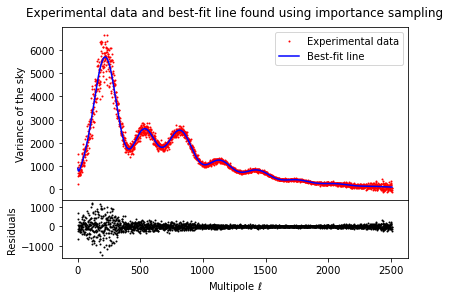

In [15]:
# Finally, plot the best-fit line over the experimental data

best_data = get_spectrum(final_means)[:2507]

fig = plt.figure(0)

top = fig.add_axes((.1,.3,.8,.6))
plt.plot(ell, spec, '.', markersize=2, color='red', label="Experimental data")
plt.plot(ell, best_data, color='blue',label="Best-fit line")
plt.legend()
plt.ylabel("Variance of the sky")
plt.title("Experimental data and best-fit line found using importance sampling",y=1.03)

res = spec-best_data
bot = fig.add_axes((.1,.1,.8,.2))
plt.plot(ell,res, '.', markersize=2, color='k')
plt.ylabel("Residuals")
plt.xlabel(r"Multipole $\ell$")
plt.savefig("multipole_importance_sampling.png",dpi=500,bbox_inches='tight')

plt.show()